## **Model and Evaluation**

## Objectives

* Fetch dataset from Kaggle and download in inputs folder
* Inspect dataset and correct if need be
* Save inspected dataset in outputs folder

## Inputs

* Kaggle JSON file - Authentication Token 

## Outputs

* Generate Dataset: outputs/datasets/collection/Sales-Records

## Additional Comments

* Dataset was found on a public data base so there were no security concerns
* Kaggle JSON file was deleted since it contained Key

---

# Change working directory

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales/jupyter_notebooks'

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/House-Sales'

---

In [4]:
import numpy as np
import pandas as pd
df_raw_path = "outputs/datasets/collection/Sales-Records"
df = pd.read_csv(df_raw_path)
df.head(10)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
5,796,566.0,1.0,No,732,GLQ,64,NaN,480,Unf,...,85.0,0.0,30,5,5,796,NaN,1993,1995,143000
6,1694,0.0,3.0,Av,1369,GLQ,317,NaN,636,RFn,...,75.0,186.0,57,5,8,1686,NaN,2004,2005,307000
7,1107,983.0,3.0,Mn,859,ALQ,216,NaN,484,NaN,...,NaN,240.0,204,6,7,1107,NaN,1973,1973,200000
8,1022,752.0,2.0,No,0,Unf,952,NaN,468,Unf,...,51.0,0.0,0,5,7,952,NaN,1931,1950,129900
9,1077,0.0,2.0,No,851,GLQ,140,NaN,205,RFn,...,50.0,0.0,4,6,5,991,NaN,1939,1950,118000


---

In [5]:
from sklearn.pipeline import Pipeline
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.encoding import OrdinalEncoder


def PipelineDataCleaningAndFeatureEngineering():
    pipeline_base = Pipeline([
        ("OrdinalCategoricalEncoder", OrdinalEncoder(encoding_method='arbitrary',
                                                     variables=['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KithcenQual'])),

        ("NumericScaler", StandardScaler()),

                                                                
        ("SmartCorrelatedSelection", SmartCorrelatedSelection(variables=None,
         method="spearman", threshold=0.6, selection_method="variance")),

    ])

    return pipeline_base


PipelineDataCleaningAndFeatureEngineering()

Pipeline(steps=[('OrdinalCategoricalEncoder',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['1stFlrSF', '2ndFlrSF',
                                           'BedroomAbvGr', 'BsmtFinSF1',
                                           'BsmtUnfSF', 'GarageArea',
                                           'GarageYrBlt', 'GrLivArea',
                                           'LotArea', 'LotFrontage',
                                           'MasVnrArea', 'OpenPorchSF',
                                           'OverallCond', 'OverallQual',
                                           'TotalBsmtSF', 'YearBuilt',
                                           'YearRemodAdd'])),
                ('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6))])

In [6]:
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier


def PipelineClf(model):
    pipeline_base = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
    ])

    return pipeline_base

/home/codeany/.local/lib/python3.8/site-packages/xgboost/compat.py:93: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [7]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = PipelineClf(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

## Split and Train

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['SalePrice'], axis=1),
    df['SalePrice'],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 23) (1168,) (292, 23) (292,)


---

## Handle Target Inbalance

In [9]:
X_train.dtypes

1stFlrSF           int64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1         int64
BsmtFinType1      object
BsmtUnfSF          int64
EnclosedPorch    float64
GarageArea         int64
GarageFinish      object
GarageYrBlt      float64
GrLivArea          int64
KitchenQual       object
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF        int64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
dtype: object

In [20]:
X_test.dtypes

1stFlrSF        object
2ndFlrSF        object
BedroomAbvGr    object
BsmtExposure    object
BsmtFinSF1      object
BsmtFinType1    object
BsmtUnfSF       object
GarageArea      object
GarageFinish    object
GarageYrBlt     object
GrLivArea       object
KitchenQual     object
LotArea         object
LotFrontage     object
MasVnrArea      object
OpenPorchSF     object
OverallCond     object
OverallQual     object
TotalBsmtSF     object
YearBuilt       object
YearRemodAdd    object
dtype: object

In [11]:
columns_to_remove = ['WoodDeckSF', 'EnclosedPorch'] 

X_train.drop(columns=columns_to_remove, inplace=True)

In [12]:
X_test.drop(columns=columns_to_remove, inplace=True)

In [14]:
thevariables=['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
            'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea',
            'GarageYrBlt', 'GrLivArea', 'LotArea', 
            'LotFrontage', 'MasVnrArea', 'OpenPorchSF',
            'OverallCond', 'OverallQual', 'TotalBsmtSF',
            'YearBuilt', 'YearRemodAdd']

In [15]:
X_train.fillna(value= 0, inplace=True)
X_test.fillna(value= 0, inplace=True)

In [19]:
X_train = X_train.astype('object')
X_test = X_test.astype('object')

In [16]:
X_train.isnull().sum()

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
dtype: int64

In [17]:
print(X_test.isnull().sum())

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
dtype: int64


In [21]:
pipeline_data_cleaning_feat_eng = PipelineDataCleaningAndFeatureEngineering()
X_train = pipeline_data_cleaning_feat_eng.fit_transform(X_train)
X_test = pipeline_data_cleaning_feat_eng.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1168, 19) (1168,) (292, 19) (292,)


/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:271: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/home/codeany/.local/lib/python3.8/site-packages/feature_engine/encoding/base_encoder.py:141: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories do not exist. Try using the RareLabelCategoricalEncoder to remove infrequ

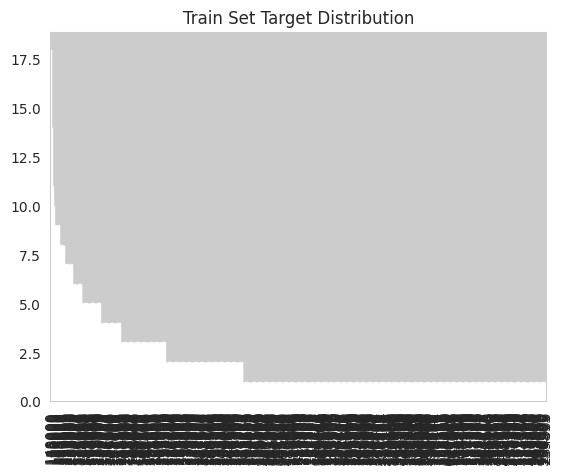

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

In [31]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

In [32]:
from sklearn.metrics import make_scorer, recall_score
search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


NotFittedError: All estimators failed to fit

/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 341, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 303, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "/home/codeany/.local/lib/python3.8/site-packages/joblib/memory.py", line 353, in __call__
    return self.func(*args, **kwargs)
  File "/home/codeany/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 754, in _fit_transform_one
    res = transformer.fit_t